## Imports & dependencies

In [54]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir
import pandas as pd
import numpy as np
import os
import random

## Download Pre-Trained Model

In [6]:


# Download a pre-trained model from the web via Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

saved_model_path = "06_101_food_class_10_percent_saved_big_dog_model.zip"
unzip_data(saved_model_path)

--2024-07-04 14:55:47--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.40.155, 142.251.40.187, 142.250.64.123, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.40.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip.2’

06_101_food_class_1 100%[===================>]  44.59M  12.7MB/s    in 3.6s    

2024-07-04 14:55:51 (12.4 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip.2’ saved [46760742/46760742]



In [7]:
# Note: loading a model will output a lot of 'WARNINGS', these can be ignored: 
# https://www.tensorflow.org/tutorials/keras/save_and_load#save_checkpoints_during_training
# There's also a thread on GitHub trying to fix these warnings: https://github.com/tensorflow/tensorflow/issues/40166
m0 = tf.keras.models.load_model(saved_model_path.split(".")[0]) # don't include ".zip" in loaded model path

## Prepare Testing data

In [8]:
imagesDirPath = "101_food_classes_10_percent/"
testDirPath = imagesDirPath + 'test/'
print(f'TEST dir: {testDirPath}')

TEST dir: 101_food_classes_10_percent/test/


In [9]:
OUTPUT_IMG_SIZE = (224,224)
testingData10p = tf.keras.preprocessing.image_dataset_from_directory(testDirPath,
                                                                label_mode="categorical",
                                                                image_size=OUTPUT_IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Found 25250 files belonging to 101 classes.


## Evaluate Model on Testing Data

In [10]:
# Check to see if loaded model is a trained model
loaded_loss, loaded_accuracy = m0.evaluate(testingData10p)
loaded_loss, loaded_accuracy

2024-07-04 14:59:36.689223: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19267584 exceeds 10% of free system memory.
2024-07-04 14:59:36.730423: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19440000 exceeds 10% of free system memory.
2024-07-04 14:59:36.806732: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 51380224 exceeds 10% of free system memory.
2024-07-04 14:59:36.813764: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19267584 exceeds 10% of free system memory.
2024-07-04 14:59:36.886056: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 51380224 exceeds 10% of free system memory.


790/790 [==============================] - 574s 725ms/step - loss: 1.8027 - accuracy: 0.6078


(1.8027209043502808, 0.6077623963356018)

## Make Predictions On New Images
The `predict()` method can be used to make predictions with the model on new data.
The data will have 101 classes.  
Each prediction will return a prediction probability tensor for each class.  

In [11]:
# Make predictions with model
pred_probs = m0.predict(testingData10p, verbose=1) # set verbosity to see how long it will take 

790/790 [==============================] - 518s 654ms/step


### Inspect The Prediction results

In [12]:
# ensure the number of predictions matches the above prediction dataset length
len(pred_probs)

25250

In [13]:
# What's the shape of our predictions?
# should return (numberOfImages, numberOfClasses)
pred_probs.shape

(25250, 101)

In [14]:
# How do they look?
pred_probs[:5]

array([[5.95420562e-02, 3.57422209e-06, 4.13774475e-02, 1.06605846e-09,
        8.16148216e-09, 8.66400640e-09, 8.09278902e-07, 8.56528175e-07,
        1.98591661e-05, 8.09779181e-07, 3.17278315e-09, 9.86745817e-07,
        2.85324582e-04, 7.80494114e-10, 7.42306467e-04, 3.89163761e-05,
        6.47409252e-06, 2.49775644e-06, 3.78914556e-05, 2.06783454e-07,
        1.55384496e-05, 8.15080284e-07, 2.62307913e-06, 2.00108175e-07,
        8.38279334e-07, 5.42160888e-06, 3.73910689e-06, 1.31505207e-08,
        2.77615339e-03, 2.80519162e-05, 6.85626056e-10, 2.55749765e-05,
        1.66889920e-04, 7.64075025e-10, 4.04530641e-04, 1.31506708e-08,
        1.79573772e-06, 1.44482146e-06, 2.30629649e-02, 8.24675567e-07,
        8.53662527e-07, 1.71386125e-06, 7.05261709e-06, 1.84021829e-08,
        2.85535123e-07, 7.94839798e-06, 2.06817094e-06, 1.85252034e-07,
        3.36197381e-08, 3.15227022e-04, 1.04109522e-05, 8.54490111e-07,
        8.47417772e-01, 1.05554955e-05, 4.40949151e-07, 3.740449

In [16]:
imageIndex = 0
aPrediction = pred_probs[imageIndex]

# We get one prediction probability per class
print(f"Number of prediction probabilities for sample {imageIndex}: {len(aPrediction)}")
print(f"What prediction probability sample {imageIndex} looks like:\n {aPrediction}")
print(f"The class with the highest predicted probability by the model for sample {imageIndex}: {aPrediction.argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [5.95420562e-02 3.57422209e-06 4.13774475e-02 1.06605846e-09
 8.16148216e-09 8.66400640e-09 8.09278902e-07 8.56528175e-07
 1.98591661e-05 8.09779181e-07 3.17278315e-09 9.86745817e-07
 2.85324582e-04 7.80494114e-10 7.42306467e-04 3.89163761e-05
 6.47409252e-06 2.49775644e-06 3.78914556e-05 2.06783454e-07
 1.55384496e-05 8.15080284e-07 2.62307913e-06 2.00108175e-07
 8.38279334e-07 5.42160888e-06 3.73910689e-06 1.31505207e-08
 2.77615339e-03 2.80519162e-05 6.85626056e-10 2.55749765e-05
 1.66889920e-04 7.64075025e-10 4.04530641e-04 1.31506708e-08
 1.79573772e-06 1.44482146e-06 2.30629649e-02 8.24675567e-07
 8.53662527e-07 1.71386125e-06 7.05261709e-06 1.84021829e-08
 2.85535123e-07 7.94839798e-06 2.06817094e-06 1.85252034e-07
 3.36197381e-08 3.15227022e-04 1.04109522e-05 8.54490111e-07
 8.47417772e-01 1.05554955e-05 4.40949151e-07 3.74044976e-05
 3.53062933e-05 3.24889443e-05 6.73150571e-

Each prediction value is a number between `0` and `1`.  
The highest prediction value out of the 101 values (classes) is the "winner" that the model chooses as the most likely class match.  

### Get & Inspect Classes

In [17]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:5]

array([52,  0,  0, 80, 79])

## Compare Predictions To The Real Results
- we have a prediction set
- we have classes
- we have the testing data

Now:
- "unwrap" the test data into a list of images & labels
- get just the labels from the test data

In [33]:
# Note: This might take a minute or so due to unravelling 790 batches
testDataLabels = []
for images, labels in testingData10p.unbatch(): # unbatch the test data and get images and labels
  testDataLabels.append(labels.numpy().argmax()) # append the INDEX which has the largest value (labels are one-hot)

In [34]:
# check what they look like
testDataLabels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [35]:
len(testDataLabels)

25250

The number of calculated labels matches the number of images.

### Get an Accuracy Score On Prediction Results

In [36]:
sklearn_accuracy = accuracy_score(testDataLabels, pred_classes)
sklearn_accuracy

0.6077623762376237

In [37]:
print(f"Close? {np.isclose(loaded_accuracy, sklearn_accuracy)} | Difference: {loaded_accuracy - sklearn_accuracy}")

Close? True | Difference: 2.0097978059574473e-08


## Visualize Predictions With a Confusion Matrix

In [40]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [41]:
testingClassNames = testingData10p.class_names

make_confusion_matrix(y_true=testDataLabels,
                      y_pred=pred_classes,
                      classes=testingClassNames,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

## Get A Classification Report

The sklearn `classification_report()` outputs the precision, recall and f1-score's per class:

- **Precision** - Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0).
- **Recall** - Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives.
- **F1 score** - Combines precision and recall into one metric. 1 is best, 0 is worst.

In [44]:
classificationReport = classification_report(testDataLabels, pred_classes)
print(classificationReport)

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

## Visualize Classification Prediction Scores By Class
### Create Dictionary of Classifictaions By Index

In [45]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(testDataLabels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584906,
  'support': 250.0},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250.0},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713755,
  'support': 250.0},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250.0},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.5440806045340051,
  'support': 250.0},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.4186046511627907,
  'support': 250.0},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250.0},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511387,
  'support': 250.0},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'sup

### Create Dictionary of Accuracy Scores By Class

In [48]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[testingClassNames[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.24056603773584906,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713755,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.5440806045340051,
 'beet_salad': 0.4186046511627907,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511387,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056105,
 'caprese_salad': 0.5775193798449613,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.3674418604651163,
 'cheese_plate': 0.5654135338345865,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.4526166902404526,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990758,
 'clam_chowder': 0.7708779443254818,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.46255506607929514,
 'creme_brulee'

#### Sort Classes By f-1 score descending

In [50]:
# Turn f1-scores into dataframe for visualization
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores.head()

class_name  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008

### Horizontal Bar

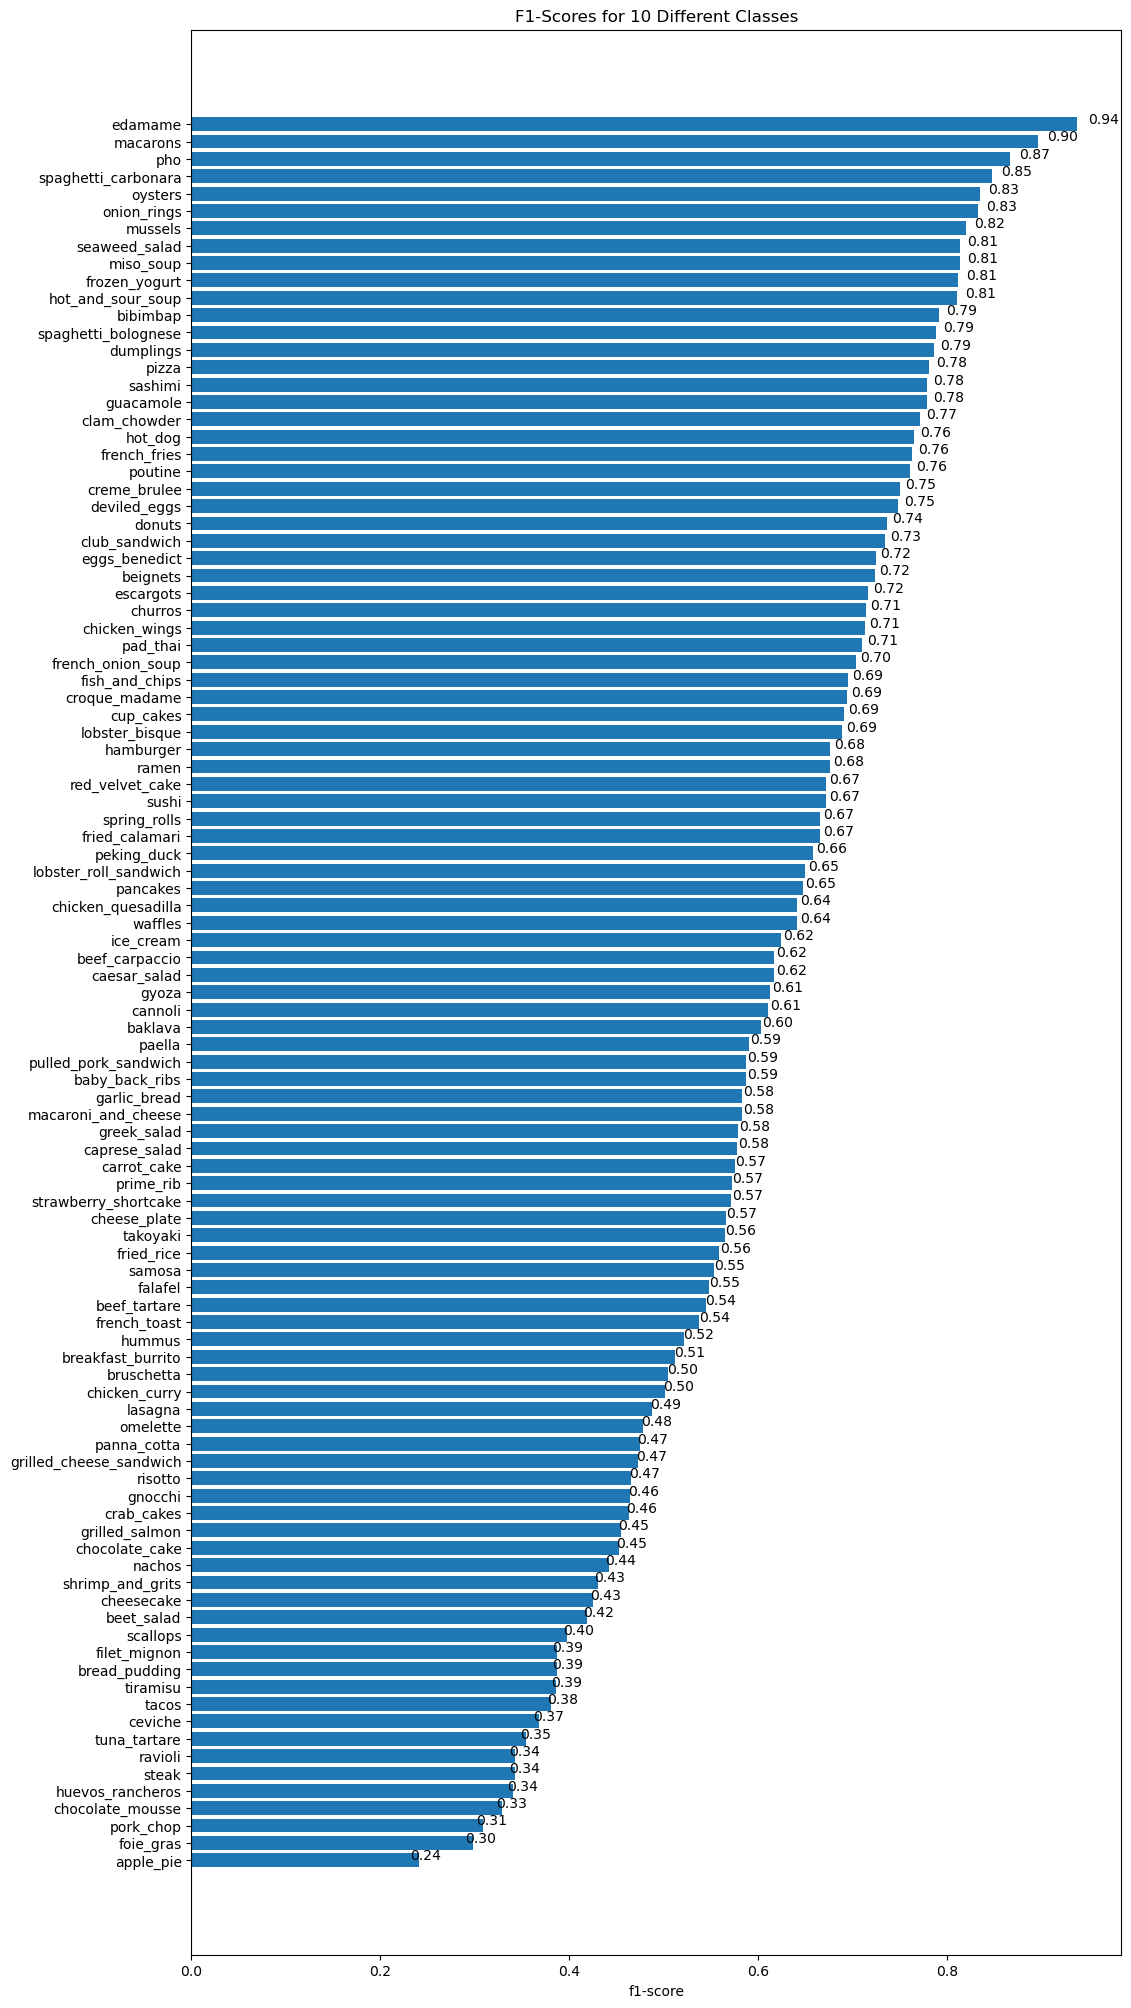

In [52]:
fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

## Visualize Predictions on Test Images

### Image Loader Function

In [53]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  # Read in the image
  img = tf.io.read_file(filename)
    
  # Decode it into a tensor
  img = tf.io.decode_image(img)
    
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
    
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

### Visualize A Few

1/1 [==============================] - 0s 100ms/step


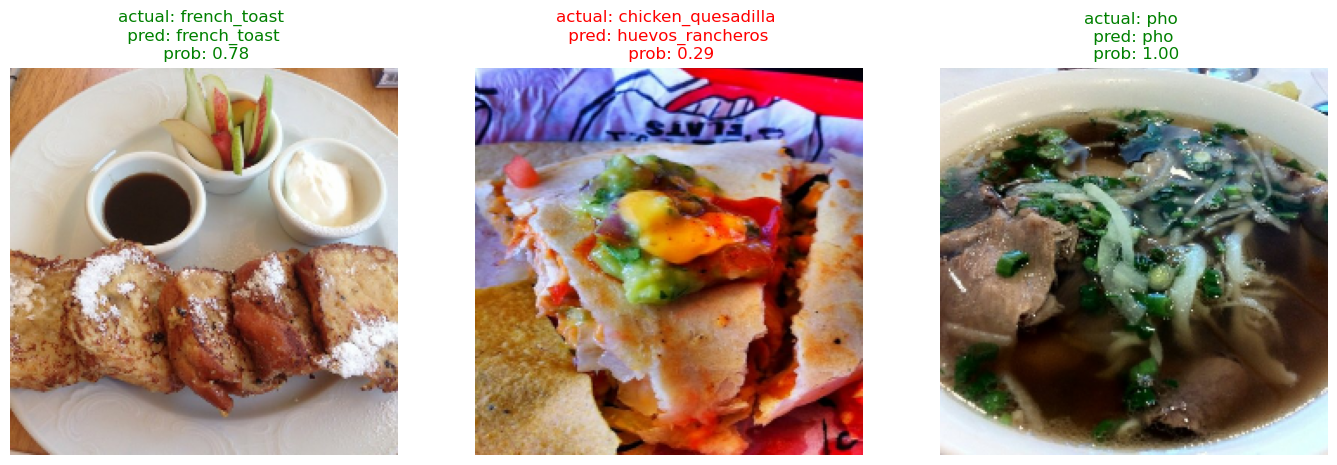

In [74]:
plt.figure(figsize=(17, 10))


for i in range(3):
  # Choose a random image from a random class 
  randomClassName = random.choice(testingClassNames)
  randomFileName = random.choice(os.listdir(testDirPath + "/" + randomClassName))
  randomFile = testDirPath + randomClassName + "/" + randomFileName

  # Load the image and make predictions
  img = load_and_prep_image(randomFile, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = m0.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = testingClassNames[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if randomClassName == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {randomClassName} \n pred: {pred_class} \n prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

## Finding & Visualizing Most-Wrong Predictions
- focus in on the wrong-"est" predictions

### Data-Prep: Collect Test Image Paths

In [80]:
# 1. Get the filenames of all of our test data
testImageFilePaths = []
for filepath in testingData10p.list_files("101_food_classes_10_percent/test/*/*.jpg", 
                                     shuffle=False):
  testImageFilePaths.append(filepath.numpy())
testImageFilePaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

### Data-Prep: Build DataFrame With Prediction Values

In [94]:
predictionsDataFrame = pd.DataFrame({"img_path": testImageFilePaths,
                                     "real_class_index": testDataLabels,
                                     "predicted_classes": pred_classes,
                                     "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                                     "real_classname": [testingClassNames[i] for i in testDataLabels],
                                     "pred_classname": [testingClassNames[i] for i in pred_classes],
                                     "pred_correct": testDataLabels == pred_classes,
                                     })

predictionsDataFrame.head()

img_path  real_class_index  \
0  b'101_food_classes_10_percent/test/apple_pie/1...                 0   
1  b'101_food_classes_10_percent/test/apple_pie/1...                 0   
2  b'101_food_classes_10_percent/test/apple_pie/1...                 0   
3  b'101_food_classes_10_percent/test/apple_pie/1...                 0   
4  b'101_food_classes_10_percent/test/apple_pie/1...                 0   

   predicted_classes  pred_conf real_classname        pred_classname  \
0                 52   0.847418      apple_pie                 gyoza   
1                  0   0.964017      apple_pie             apple_pie   
2                  0   0.959259      apple_pie             apple_pie   
3                 80   0.658606      apple_pie  pulled_pork_sandwich   
4                 79   0.367901      apple_pie             prime_rib   

   pred_correct  
0         False  
1          True  
2          True  
3         False  
4         False

### Data-Prep: Sort & Get most incorrect

In [113]:
# 4. Get the top 100 wrong examples
wrongSorted = predictionsDataFrame[predictionsDataFrame["pred_correct"] == False].sort_values("pred_conf", ascending=False)
# wrongSorted.head(20)
top_100_wrong = wrongSorted[:100]
top_100_wrong.head(20)

img_path  real_class_index  \
21810  b'101_food_classes_10_percent/test/scallops/17...                87   
231    b'101_food_classes_10_percent/test/apple_pie/8...                 0   
15359  b'101_food_classes_10_percent/test/lobster_rol...                61   
23539  b'101_food_classes_10_percent/test/strawberry_...                94   
21400  b'101_food_classes_10_percent/test/samosa/3140...                85   
24540  b'101_food_classes_10_percent/test/tiramisu/16...                98   
2511   b'101_food_classes_10_percent/test/bruschetta/...                10   
5574   b'101_food_classes_10_percent/test/chocolate_m...                22   
17855  b'101_food_classes_10_percent/test/paella/2314...                71   
23797  b'101_food_classes_10_percent/test/sushi/16593...                95   
18001  b'101_food_classes_10_percent/test/pancakes/10...                72   
11642  b'101_food_classes_10_percent/test/garlic_brea...                46   
10847  b'101_food_classes_10_percent/test/fried_calam...                43   
23631  b'101_food_classes_10_percent/test/strawberry_...                94   
1155   b'101_food_classes_10_percent/test/beef_tartar...                 4   
10854  b'101_food_classes_10_percent/test/fried_calam...                43   
23904  b'101_food_classes_10_percent/test/sushi/33652...                95   
7316   b'101_food_classes_10_percent/test/cup_cakes/1...                29   
13144  b'101_food_classes_10_percent/test/gyoza/31214...                52   
10880  b'101_food_classes_10_percent/test/fried_calam...                43   

       predicted_classes  pred_conf         real_classname  \
21810                 29   0.999997               scallops   
231                  100   0.999995              apple_pie   
15359                 53   0.999988  lobster_roll_sandwich   
23539                 83   0.999987   strawberry_shortcake   
21400                 92   0.999981                 samosa   
24540                 83   0.999947               tiramisu   
2511                  61   0.999945             bruschetta   
5574                  21   0.999939       chocolate_mousse   
17855                 65   0.999931                 paella   
23797                 86   0.999904                  sushi   
18001                 67   0.999904               pancakes   
11642                 10   0.999877           garlic_bread   
10847                 68   0.999872         fried_calamari   
23631                 83   0.999858   strawberry_shortcake   
1155                   5   0.999858           beef_tartare   
10854                 68   0.999854         fried_calamari   
23904                 86   0.999823                  sushi   
7316                  83   0.999817              cup_cakes   
13144                 92   0.999799                  gyoza   
10880                 68   0.999778         fried_calamari   

              pred_classname  pred_correct  
21810              cup_cakes         False  
231                  waffles         False  
15359              hamburger         False  
23539        red_velvet_cake         False  
21400           spring_rolls         False  
24540        red_velvet_cake         False  
2511   lobster_roll_sandwich         False  
5574          chocolate_cake         False  
17855                mussels         False  
23797                sashimi         False  
18001               omelette         False  
11642             bruschetta         False  
10847            onion_rings         False  
23631        red_velvet_cake         False  
1155              beet_salad         False  
10854            onion_rings         False  
23904                sashimi         False  
7316         red_velvet_cake         False  
13144           spring_rolls         False  
10880            onion_rings         False

### Visualize Most-Wrong Predictions

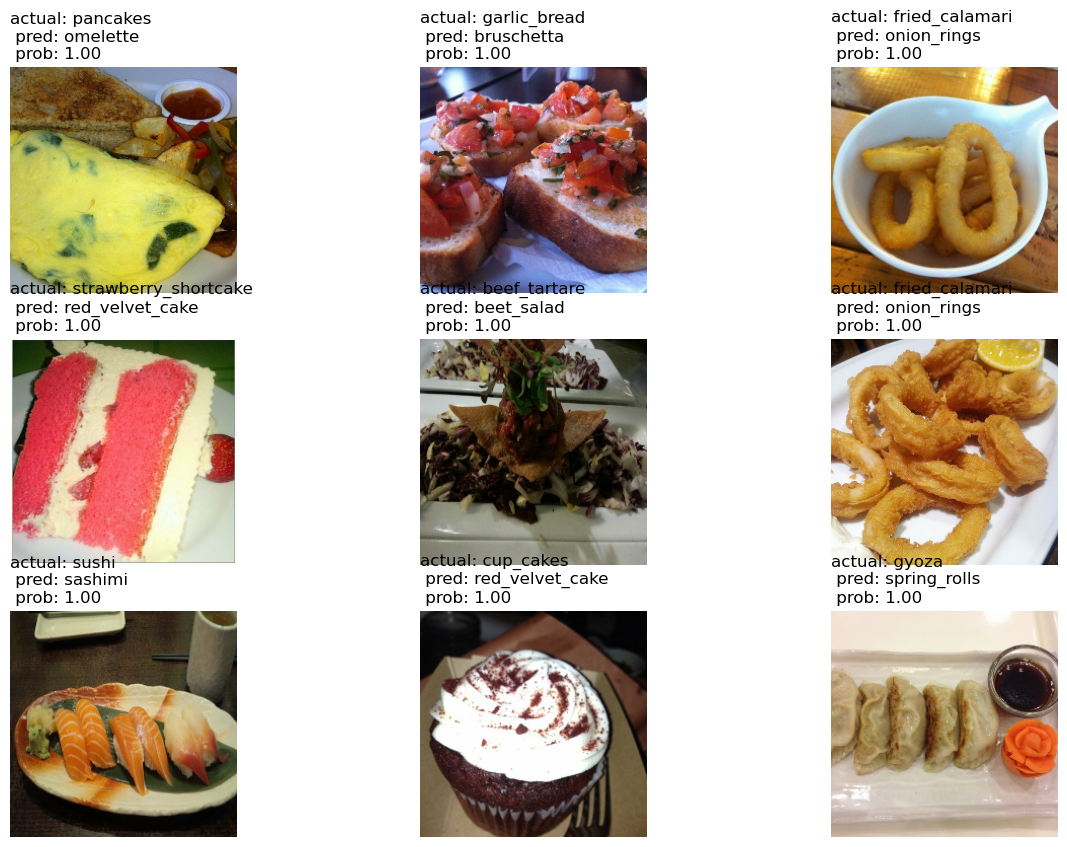

In [98]:
images_to_view = 9
start_index = 10 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()): 
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true} \n pred: {y_pred} \n prob: {pred_prob:.2f}", loc="left")
  plt.axis(False)

### Group & Count Incorrect Classifications

In [138]:
top_250_wrong = wrongSorted[:250]
top_250_wrong.head(20)
justRealClasses = top_250_wrong[['real_classname', 'pred_classname']].copy()
mismatchedLabels = justRealClasses.groupby(['real_classname', 'pred_classname']).size().to_frame('size').sort_values(by="size", ascending=False)
mismatchedLabels.head(20)

size
real_classname          pred_classname         
chocolate_mousse        chocolate_cake        5
ice_cream               frozen_yogurt         4
strawberry_shortcake    red_velvet_cake       4
paella                  mussels               4
dumplings               gyoza                 3
sushi                   sashimi               3
ceviche                 greek_salad           3
fried_calamari          onion_rings           3
tiramisu                chocolate_cake        3
chocolate_cake          red_velvet_cake       2
chicken_curry           lobster_bisque        2
grilled_cheese_sandwich club_sandwich         2
filet_mignon            steak                 2
ceviche                 sashimi               2
filet_mignon            prime_rib             2
spring_rolls            samosa                2
carrot_cake             chocolate_cake        2
escargots               french_onion_soup     2
steak                   baby_back_ribs        2
                        filet_mignon          2

## Predict & Visualize on new images
### Get Images

In [139]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip")

--2024-07-05 16:25:07--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.40.155, 142.251.40.187, 142.250.64.91, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.40.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  11.9MB/s    in 1.1s    

2024-07-05 16:25:08 (11.9 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



### Get Image file paths

In [143]:
custom_food_images_list = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images_list

['custom_food_images/hamburger.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/pizza-dad.jpeg']

### Loop, Predict, and visualize

1/1 [==============================] - 0s 56ms/step


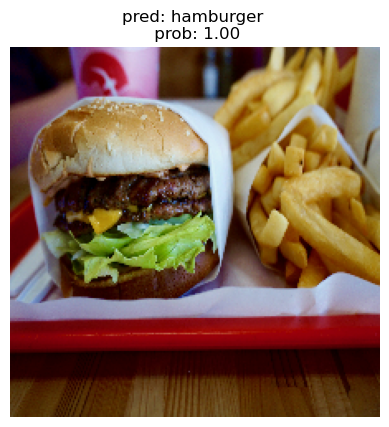

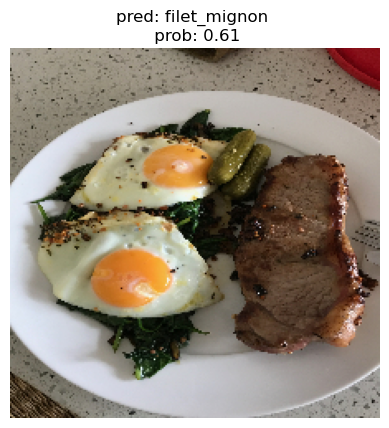

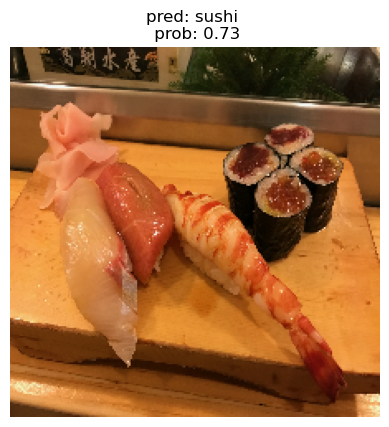

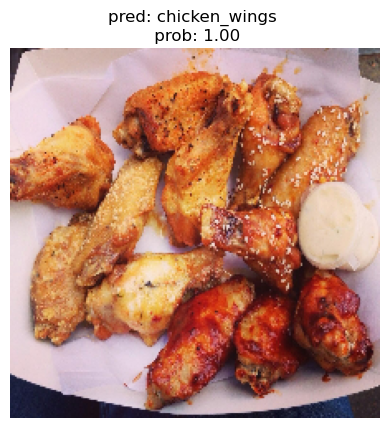

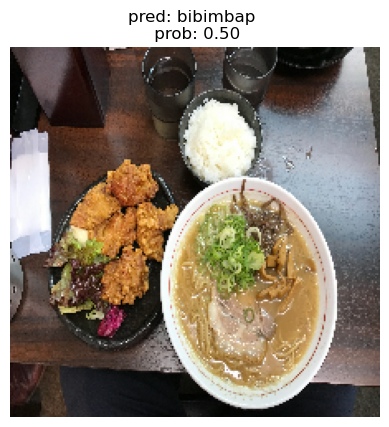

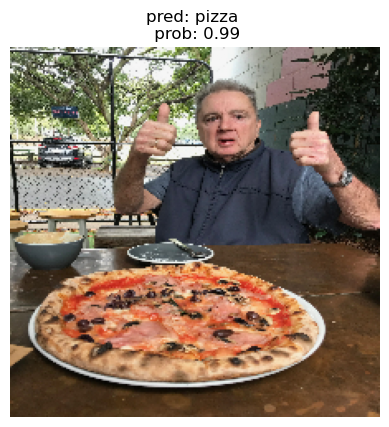

In [147]:
# Make predictions on custom food images
for img in custom_food_images_list:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = m0.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = testingClassNames[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class} \n prob: {pred_prob.max():.2f}")
  plt.axis(False)